In [9]:
import cv2 as cv
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
import time
from pathlib import Path

from pprint import pprint
from collections import OrderedDict

from multiprocessing import Pool, cpu_count, Queue
from scipy.cluster.vq import kmeans2
from sklearn.decomposition import LatentDirichletAllocation 
from sklearn.preprocessing import normalize
pd.options.mode.chained_assignment = None


In [10]:
#简单二值化，自己设置阈值
def Two(image):
    w,h = image.shape
    size = (w,h)
    iTwo = image
    for i in range(w):
        for j in range(h):
            if image[i,j]>100:
                iTwo[i,j] = 1
            else:
                iTwo[i,j] = 0
    return iTwo 

In [11]:
# 细化
def neighbours(x,y,image):
    "Return 8-neighbours of image point P1(x,y), in a clockwise order"
    img = image
    x_1, y_1, x1, y1 = x-1, y-1, x+1, y+1
    return [ img[x_1][y], img[x_1][y1], img[x][y1], img[x1][y1],     # P2,P3,P4,P5
                img[x1][y], img[x1][y_1], img[x][y_1], img[x_1][y_1] ]    # P6,P7,P8,P9

def transitions(neighbours):
    "No. of 0,1 patterns (transitions from 0 to 1) in the ordered sequence"
    n = neighbours + neighbours[0:1]      # P2, P3, ... , P8, P9, P2
    return sum( (n1, n2) == (0, 1) for n1, n2 in zip(n, n[1:]) )  # (P2,P3), (P3,P4), ... , (P8,P9), (P9,P2)

def zhangSuen(image):
    "the Zhang-Suen Thinning Algorithm"
    Image_Thinned = image.copy()  # deepcopy to protect the original image
    changing1 = changing2 = 1        #  the points to be removed (set as 0)
    while changing1 or changing2:   #  iterates until no further changes occur in the image
        # Step 1
        changing1 = []
        rows, columns = Image_Thinned.shape               # x for rows, y for columns
        for x in range(1, rows - 1):                     # No. of  rows
            for y in range(1, columns - 1):            # No. of columns
                P2,P3,P4,P5,P6,P7,P8,P9 = n = neighbours(x, y, Image_Thinned)
                if (Image_Thinned[x][y] == 1     and    # Condition 0: Point P1 in the object regions 
                    2 <= sum(n) <= 6   and    # Condition 1: 2<= N(P1) <= 6
                    transitions(n) == 1 and    # Condition 2: S(P1)=1  
                    P2 * P4 * P6 == 0  and    # Condition 3   
                    P4 * P6 * P8 == 0):         # Condition 4
                    changing1.append((x,y))
        for x, y in changing1: 
            Image_Thinned[x][y] = 0
        # Step 2
        changing2 = []
        for x in range(1, rows - 1):
            for y in range(1, columns - 1):
                P2,P3,P4,P5,P6,P7,P8,P9 = n = neighbours(x, y, Image_Thinned)
                if (Image_Thinned[x][y] == 1   and        # Condition 0
                    2 <= sum(n) <= 6  and       # Condition 1
                    transitions(n) == 1 and      # Condition 2
                    P2 * P4 * P8 == 0 and       # Condition 3
                    P2 * P6 * P8 == 0):            # Condition 4
                    changing2.append((x,y))    
        for x, y in changing2: 
            Image_Thinned[x][y] = 0
    return Image_Thinned
 


In [12]:
#膨胀细化
def map_segment(map_src):
    #img = cv.imread('E:/Program Files/jupyter_code/first/images/shang1.png',0)
    img = cv.imread(map_src,0)
    iTwo2 = Two(img)
    
#     cv.imshow("iTwo", iTwo2*255)
#     cv.waitKey(0)
    
    kernel = np.ones((5,5),np.uint8)
    dilated = cv.dilate(iTwo2, kernel, iterations = 1)
    dilated_src = os.path.join(os.path.dirname(map_src), 'dilated.png')
    cv.imwrite('out/dilated.png', dilated*255)
    cv.imwrite('out/dilated2.png', 255-dilated*255)
    img_after = cv.imread('out/dilated.png', 0)
    # 调用自己实现的细化函数
    img_after = zhangSuen(dilated)
#     cv.imshow("bin1",bin1*255)
#     cv.waitKey(0)
    plt.figure('dilated')
    plt.imshow(dilated*255, cmap='gray')    
    
    plt.figure('processed')
    plt.imshow(img_after*255, cmap='gray')
    plt.show()
    cv.imwrite('out/thinning.png', img_after*255)
    cv.imwrite('out/thinning2.png', 255-img_after*255)

#膨胀细化
def map_segment(map_src):
    #img = cv.imread('E:/Program Files/jupyter_code/first/images/shang1.png',0)
    img = cv.imread(map_src,0)
    # 自定义二值化函数，二值化图片
    iTwo2 = Two(img)
    
#     cv.imshow("iTwo", iTwo2*255)
#     cv.waitKey(0)
    
    kernel = np.ones((5,5),np.uint8)
    #使用cv自带的膨胀方式膨胀
    dilated = cv.dilate(iTwo2, kernel, iterations = 1)
    cv.imwrite('out/dilated.png', dilated*255)
    img_after = cv.imread('out/dilated.png', 0)
    # 调用自己参考zhang_suen细化算法实现的细化函数
    img_after = zhangSuen(dilated)
    plt.figure('dilated')
    plt.imshow(dilated*255, cmap='gray')    
    
    plt.figure('processed')
    plt.imshow(img_after*255, cmap='gray')
    plt.show()
    cv.imwrite('out/thinning.png', img_after*255)


In [13]:
# 连通区域划分
from skimage import measure
from skimage import filters
import geopandas as gpd

def binarize(img):
    return cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 5, 10)



def ccl(map_src, save2disk=False):
    img = cv.imread(str(map_src), 0)
    blobs =  binarize(img)

    # kernel = np.ones((10,10), np.float32) / 25
    blobs = blobs / 255
    # all_labels = measure.label(blobs, connectivity=2)
    blobs_labels = measure.label(blobs, neighbors=8, connectivity=1, background=0)
    #connectivity=1采用四联通
    np.savetxt('region_labeled.csv', blobs_labels, fmt='%d')

    if save2disk:
        plt.figure('ccl')
        plt.imshow(blobs_labels, cmap='nipy_spectral')
        plt.axis('off')
        plt.show(block=False)
        plt.imsave('out/ccl.png', blobs_labels, cmap='Spectral')
        time.sleep(3)
        plt.close()
    return blobs_labels

In [6]:
def main():
    map_segment('E:\Program Files\jupyter_code\code\images\shanghai3w.png')
    ccl('E:\Program Files\jupyter_code\code\out\thinning.png',True)

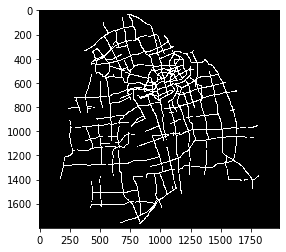

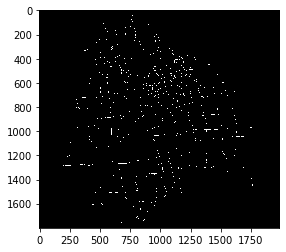

In [14]:
map_segment('E:\Program Files\jupyter_code\code\images\shanghai3w.png')

In [37]:
    img = cv.imread('E:\Program Files\jupyter_code\code\images\shanghai3w.png',0)
    iTwo2 = Two(img)
    cv.imshow("iTwo", iTwo2*255)
    cv.waitKey(0)
    
    
    kernel = np.ones((5,5),np.uint8)
    dilated = cv.dilate(iTwo2, kernel, iterations = 1)
    cv.imshow("iTwo", dilated*255)
    cv.waitKey(0)

-1

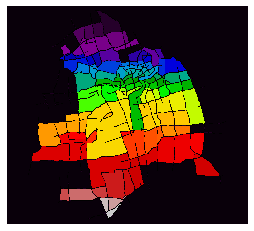

In [57]:
blobs_labels=ccl("thinning.png",True)

In [58]:
aa=set()
for row in blobs_labels:
    for cell in row:
        #print(cell)
        aa.add(cell)
# for xx in np.nditer(blobs_labels):
#     print (xx, end=", " )
    
print(len(aa))
print(aa)

159
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158}
